# Building a Gender Classifier Model using CNN

## Importing required libraries and modules

TensorFlow and Keras are used for deep learning, and other libraries like OpenCV, NumPy, and Matplotlib are used for image processing, data manipulation, and visualization.

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Activation
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc
import seaborn as sns
from tensorflow.keras.models import load_model
import numpy as np
import random
import cv2
import os
import glob

## EDA

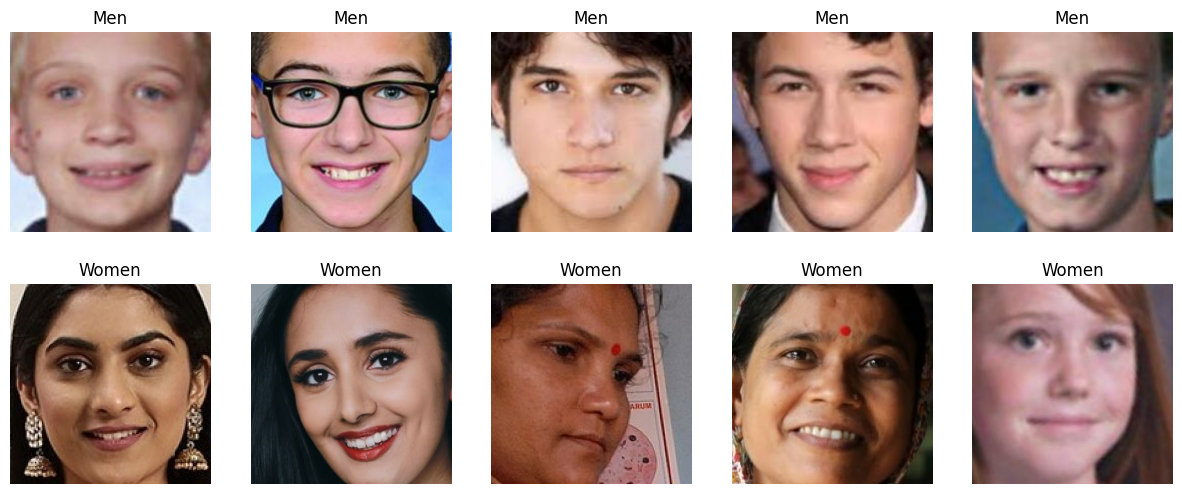

In [20]:
men_folder = './Model Enhancement/Dataset preparation/Gender Dataset (16-60)/man'
women_folder = './Model Enhancement/Dataset preparation/Gender Dataset (16-60)/woman'

men_images = [cv2.imread(os.path.join(men_folder, img)) for img in os.listdir(men_folder)[:5]]
women_images = [cv2.imread(os.path.join(women_folder, img)) for img in os.listdir(women_folder)[:5]]

# Plot sample images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    axes[0, i].imshow(cv2.cvtColor(men_images[i], cv2.COLOR_BGR2RGB))
    axes[0, i].axis('off')
    axes[0, i].set_title('Men')

    axes[1, i].imshow(cv2.cvtColor(women_images[i], cv2.COLOR_BGR2RGB))
    axes[1, i].axis('off')
    axes[1, i].set_title('Women')

plt.show()

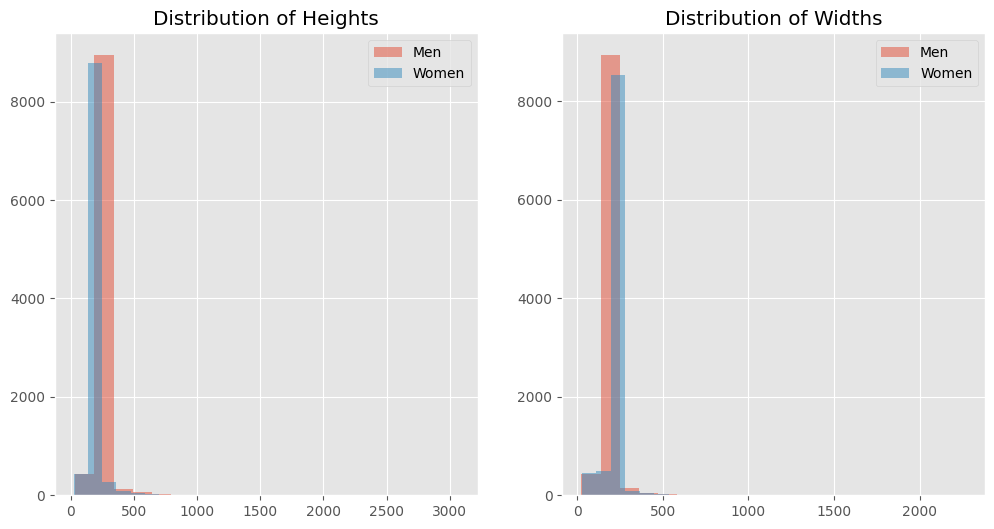

In [73]:
men_images = [cv2.imread(os.path.join(men_folder, img)) for img in os.listdir(men_folder)[:]]
women_images = [cv2.imread(os.path.join(women_folder, img)) for img in os.listdir(women_folder)[:]]


men_image_sizes = [img.shape for img in men_images]
women_image_sizes = [img.shape for img in women_images]

men_heights = [img.shape[0] for img in men_images]
men_widths = [img.shape[1] for img in men_images]

women_heights = [img.shape[0] for img in women_images]
women_widths = [img.shape[1] for img in women_images]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(men_heights, bins=20, alpha=0.5, label='Men')
plt.hist(women_heights, bins=20, alpha=0.5, label='Women')
plt.title('Distribution of Heights')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(men_widths, bins=20, alpha=0.5, label='Men')
plt.hist(women_widths, bins=20, alpha=0.5, label='Women')
plt.title('Distribution of Widths')
plt.legend()

plt.show()


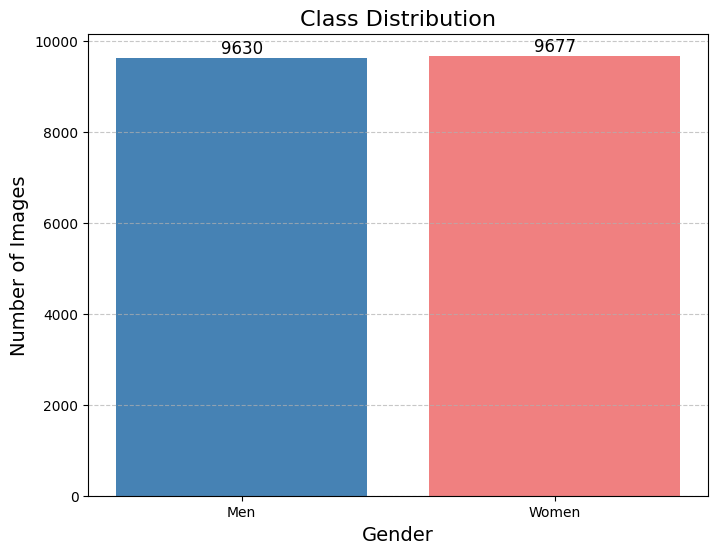

In [21]:
import os
import matplotlib.pyplot as plt

# Assuming men_folder and women_folder are defined
men_count = len(os.listdir(men_folder))
women_count = len(os.listdir(women_folder))

# Bar chart with styling
plt.figure(figsize=(8, 6))
bars = plt.bar(['Men', 'Women'], [men_count, women_count], color=['steelblue', 'lightcoral'])

# Add data labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval), ha='center', va='bottom', color='black', fontsize=12)

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Title and labels
plt.title('Class Distribution', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)

# Show the plot
plt.show()


## Initial Parameters
    
These are the hyperparameters for the model, such as the number of epochs, learning rate, batch size, and image dimensions.

In [2]:
epochs = 35
batch_size = 64
img_dims = (96, 96, 3)

## Loading and preprocessing the image

Images are loaded from a specified directory, resized to the specified dimensions, converted to arrays, and then shuffled. Labels are extracted from the file paths, and the data and labels are stored in separate lists.

In [ ]:
data = []
labels = []

# Load image files from the dataset
image_files = [f for f in glob.glob(r'Dataset preparation/Gender Dataset (16-60)' + "/**/*", recursive=True) if not os.path.isdir(f)]
random.shuffle(image_files)

# Converting images to arrays and labeling the categories
for img in image_files:
    image = cv2.imread(img)
    image = cv2.resize(image, (img_dims[0], img_dims[1]))
    image = img_to_array(image)
    data.append(image)

    label = img.split(os.path.sep)[-2]  # C:\Files\gender_dataset_face\woman\face_1162.jpg
    if label == "Woman":
        label = 1
    else:
        label = 0

    labels.append(label)  # [1, 0, 0, ...]


## Data Preprocessing

Images are converted to NumPy arrays and normalized to values between 0 and 1.

In [4]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

## Splitting the data set using train_test_split

In [5]:
trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.2, random_state=42)

## One-Hot Encoding

The labels are one-hot encoded to be compatible with the model.

In [6]:
trainY = to_categorical(trainY, num_classes=2)  # [[1, 0], [0, 1], [0, 1], ...]
testY = to_categorical(testY, num_classes=2)

## Learning rate scheduler

In [3]:
# Learning rate schedule
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 32:
        lr *= 0.5
    elif epoch > 28:
        lr *= 0.7
    elif epoch > 20:
        lr *= 0.9
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

## Defining the model

In [4]:
def swish(x):
    return x * K.sigmoid(x)

def build(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1

    model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
    model.add(Activation(swish))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation(swish))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation(swish))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation(swish))
    model.add(BatchNormalization(axis=chanDim))

    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation(swish))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation(swish))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(classes))
    model.add(Activation("sigmoid"))

    return model


## Model Architecture

The model is defined using a function build, which creates a convolutional neural network with several convolutional, activation, normalization, pooling, dropout, and fully connected layers.

In [5]:
model = build(width=img_dims[0], height=img_dims[1], depth=img_dims[2], classes=2)

## Model Compilation

The model is compiled with a binary cross-entropy loss function and the Adam optimizer.

In [6]:
# Compile the model
opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3, decay=1e-3 / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

## Model Architecture View

In [18]:
import visualkeras

visualkeras.layered_view(model).show()

## Model Training

The model is trained using the training data and validated using the test data. Training history is stored in the variable `H`.

In [ ]:
# Train the model
H = model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=batch_size, epochs=epochs, verbose=1,
              callbacks=[lr_scheduler])

## Saving the model

In [ ]:
# Save the model to disk
model.save('gender_detection_largeDataset_v2.model')

## Plotting Training History

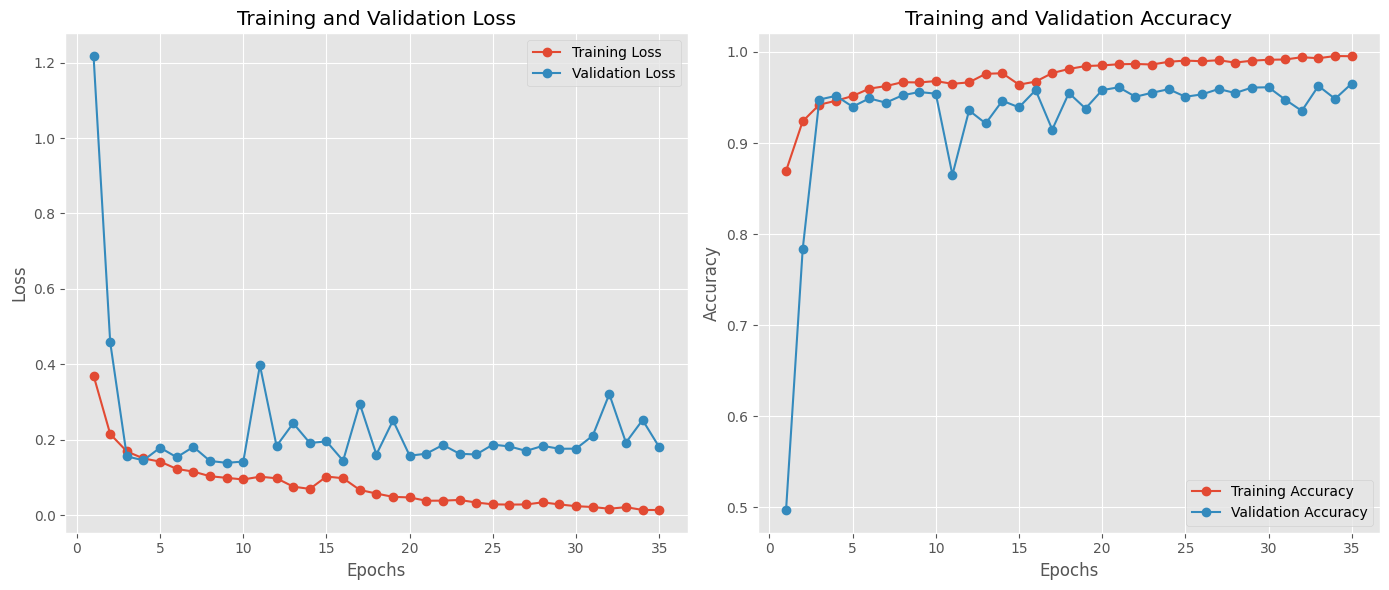

In [12]:
# lost the values stored in the variable H after training and saving the model. The notebook was closed, so used an AI tool to retrieve the data as a list from the verbose output of the training phase.
epochs = list(range(1, 36))

train_loss = [0.3700, 0.2150, 0.1688, 0.1501, 0.1418, 0.1224, 0.1153, 0.1030, 0.0987, 0.0944, 0.1018, 0.0976, 0.0754, 0.0694, 0.1022, 0.0977, 0.0667, 0.0571, 0.0483, 0.0468, 0.0380, 0.0383, 0.0401, 0.0333, 0.0285, 0.0278, 0.0282, 0.0338, 0.0282, 0.0236, 0.0214, 0.0168, 0.0210, 0.0136, 0.0134]
val_loss = [1.2174, 0.4584, 0.1556, 0.1452, 0.1788, 0.1533, 0.1809, 0.1434, 0.1386, 0.1419, 0.3973, 0.1833, 0.2436, 0.1912, 0.1954, 0.1442, 0.2955, 0.1606, 0.2510, 0.1575, 0.1628, 0.1860, 0.1626, 0.1607, 0.1869, 0.1820, 0.1702, 0.1835, 0.1759, 0.1761, 0.2103, 0.3207, 0.1923, 0.2521, 0.1803]

train_accuracy = [0.8694, 0.9239, 0.9421, 0.9464, 0.9516, 0.9597, 0.9625, 0.9668, 0.9665, 0.9680, 0.9650, 0.9666, 0.9760, 0.9766, 0.9641, 0.9674, 0.9768, 0.9813, 0.9845, 0.9852, 0.9865, 0.9868, 0.9862, 0.9892, 0.9905, 0.9898, 0.9909, 0.9883, 0.9904, 0.9914, 0.9917, 0.9942, 0.9931, 0.9955, 0.9953]
val_accuracy = [0.4972, 0.7835, 0.9477, 0.9518, 0.9399, 0.9490, 0.9443, 0.9524, 0.9560, 0.9542, 0.8651, 0.9358, 0.9215, 0.9464, 0.9392, 0.9581, 0.9148, 0.9549, 0.9379, 0.9581, 0.9612, 0.9508, 0.9552, 0.9591, 0.9508, 0.9534, 0.9593, 0.9549, 0.9609, 0.9612, 0.9477, 0.9353, 0.9627, 0.9485, 0.9653]
plt.style.use('ggplot')

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Model Evaluation

### Confusion Matrix and ROC Curve

19/19 [==============================] - 5s 245ms/step


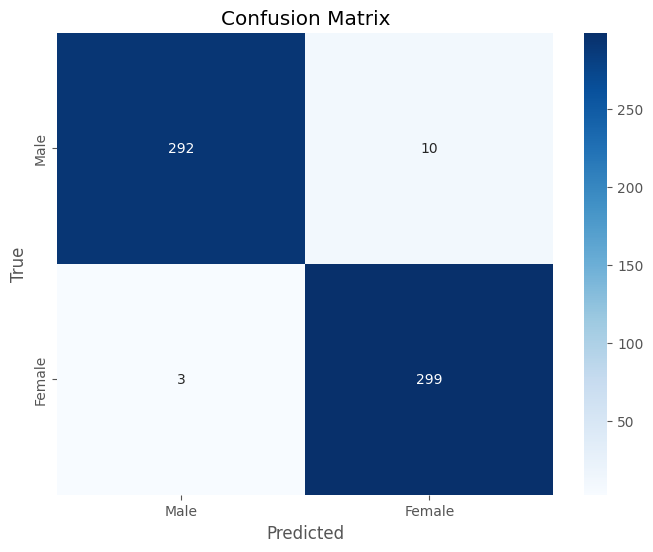

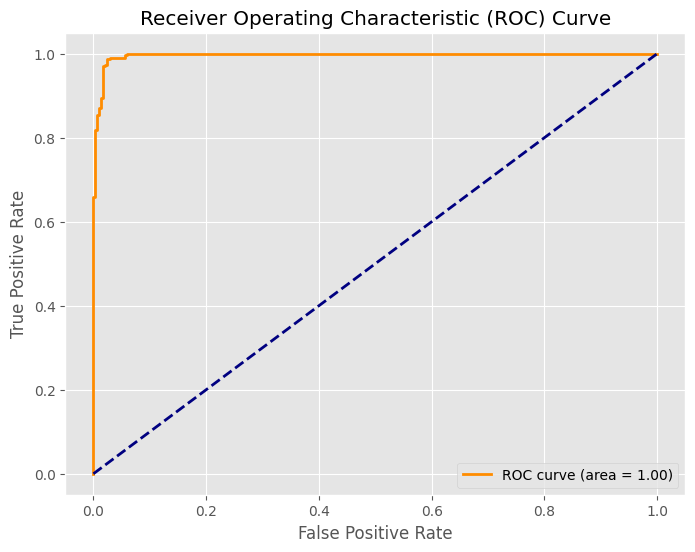

In [51]:
# Load the saved model
loaded_model = load_model('gender_detection_largeDataset_v2.model')

# Initial parameters
img_dims = (96, 96, 3)
num_images_per_folder = 302

data = []
labels = []

# Load image files from the dataset
for gender_folder in ["man", "woman"]:
    gender_path = os.path.join('./Dataset preparation/Gender Dataset (16-60)', gender_folder)
    image_files = [f for f in glob.glob(os.path.join(gender_path, '*')) if not os.path.isdir(f)][:num_images_per_folder]
    np.random.shuffle(image_files)

    # Converting images to arrays and labeling the categories
    for img in image_files:
        # Load the image
        image = cv2.imread(img)

        # Check if the image is loaded successfully
        if image is None:
            print(f"Error loading image: {img}")
            continue

        # Check if the image has valid dimensions
        if image.shape[0] == 0 or image.shape[1] == 0:
            print(f"Empty image: {img}")
            continue

        # Resize the image and convert to array
        image = cv2.resize(image, (img_dims[0], img_dims[1]))
        image = img_to_array(image)
        data.append(image)

        # Label the image
        labels.append(1 if gender_folder == "woman" else 0)

# Pre-processing
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# Convert labels to categorical format
labels_categorical = to_categorical(labels, num_classes=2)

# Predict the labels for the entire test set using the loaded model
y_pred = loaded_model.predict(data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(labels_categorical, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Male", "Female"],
            yticklabels=["Male", "Female"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [52]:
cm

array([[292,  10],
       [  3, 299]], dtype=int64)

In [57]:
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=["Woman", "Man"]))

Classification Report:
              precision    recall  f1-score   support

       Woman       0.99      0.97      0.98       302
         Man       0.97      0.99      0.98       302

    accuracy                           0.98       604
   macro avg       0.98      0.98      0.98       604
weighted avg       0.98      0.98      0.98       604



### Precision - Recall Curve

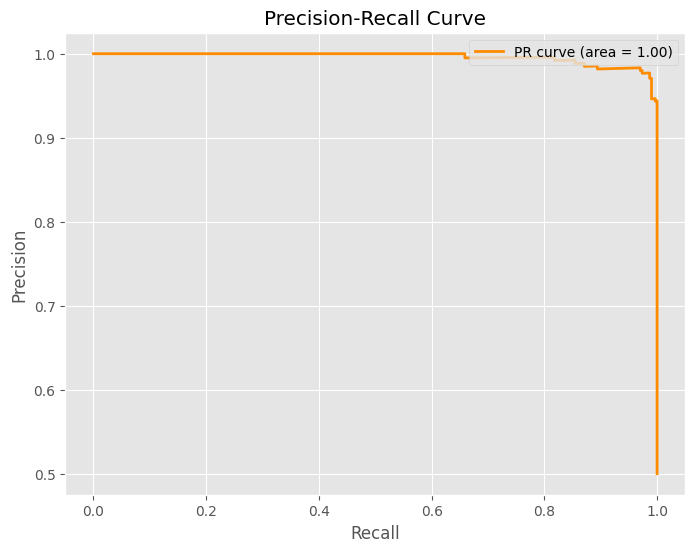

In [56]:
# Use the variables from the previous code
precision, recall, _ = precision_recall_curve(y_true, y_pred[:, 1])
pr_auc = auc(recall, precision)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (area = {:.2f})'.format(pr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


19/19 [==============================] - 5s 183ms/step


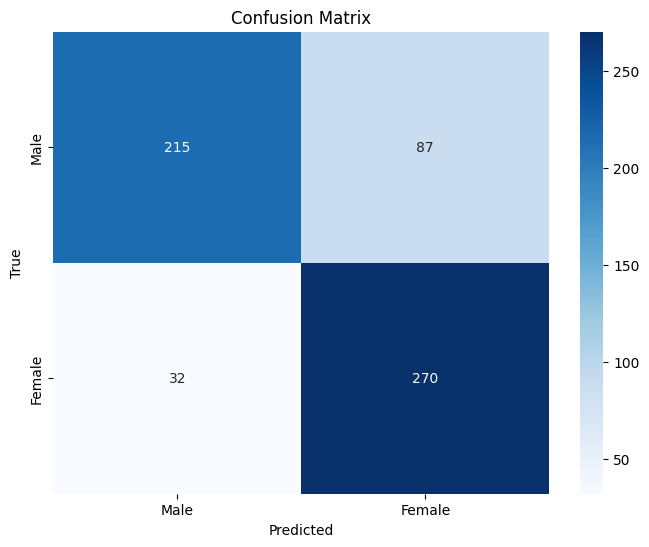

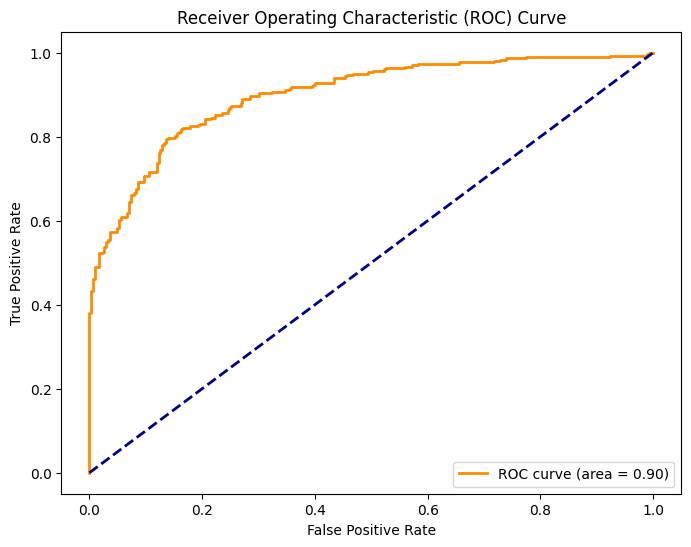

In [3]:
# Load the saved model
loaded_model = load_model('gender_detection.model')

# Initial parameters
img_dims = (96, 96, 3)
num_images_per_folder = 302

data = []
labels = []

# Load image files from the dataset
for gender_folder in ["man", "woman"]:
    gender_path = os.path.join('./Model Enhancement/Dataset preparation/Gender Dataset (16-60)', gender_folder)
    image_files = [f for f in glob.glob(os.path.join(gender_path, '*')) if not os.path.isdir(f)][:num_images_per_folder]
    np.random.shuffle(image_files)

    # Converting images to arrays and labeling the categories
    for img in image_files:
        # Load the image
        image = cv2.imread(img)

        # Check if the image is loaded successfully
        if image is None:
            print(f"Error loading image: {img}")
            continue

        # Check if the image has valid dimensions
        if image.shape[0] == 0 or image.shape[1] == 0:
            print(f"Empty image: {img}")
            continue

        # Resize the image and convert to array
        image = cv2.resize(image, (img_dims[0], img_dims[1]))
        image = img_to_array(image)
        data.append(image)

        # Label the image
        labels.append(1 if gender_folder == "woman" else 0)

# Pre-processing
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# Convert labels to categorical format
labels_categorical = to_categorical(labels, num_classes=2)

# Predict the labels for the entire test set using the loaded model
y_pred = loaded_model.predict(data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(labels_categorical, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Male", "Female"],
            yticklabels=["Male", "Female"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [4]:
cm

array([[215,  87],
       [ 32, 270]], dtype=int64)

In [7]:
from sklearn.metrics import classification_report

In [8]:
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=["Woman", "Man"]))

Classification Report:
              precision    recall  f1-score   support

       Woman       0.87      0.71      0.78       302
         Man       0.76      0.89      0.82       302

    accuracy                           0.80       604
   macro avg       0.81      0.80      0.80       604
weighted avg       0.81      0.80      0.80       604



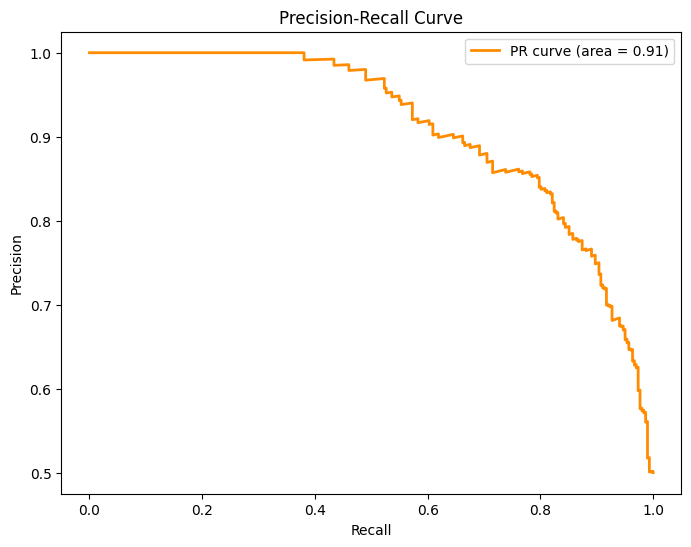

In [9]:
# Use the variables from the previous code
precision, recall, _ = precision_recall_curve(y_true, y_pred[:, 1])
pr_auc = auc(recall, precision)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (area = {:.2f})'.format(pr_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


Found 19307 images belonging to 2 classes.
1/1 [==============================] - 0s 117ms/step


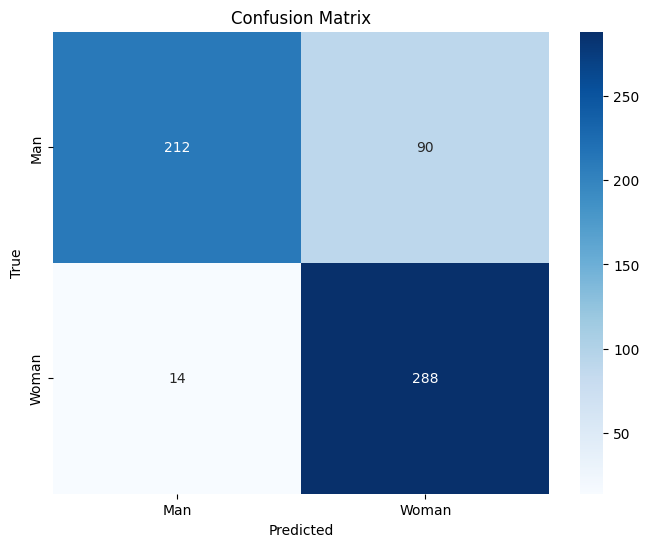

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

import seaborn as sns
from tensorflow.keras.models import load_model

# Directory containing the test images
test_data_dir = './Model Enhancement/Dataset preparation/Gender Dataset (16-60)'  # Replace with the path to your test data directory
img_width, img_height = 96, 96  # Adjust based on your image dimensions
batch_size = 64

# Create a data generator for the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',  # Adjust based on your problem (binary or categorical)
    shuffle=False  # Set to False for evaluation
)

# Load your pre-trained VGG16 model
vgg16_model = load_model('gender_classification_vgg16_model.model')  # Replace with the path to your VGG16 model

# Initialize lists to store true labels and predicted labels
y_true = []
y_pred = []

# Iterate over subdirectories (Man and Woman)
for class_label in ['Man', 'Woman']:
    class_path = os.path.join(test_data_dir, class_label)

    # Check if it's a directory
    if os.path.isdir(class_path):
        # List all image files in the subdirectory
        image_files = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

        # Select 302 images from each subdirectory
        image_files = image_files[:302]

        # Iterate over test images
        for img_path in image_files:
            # Load and preprocess the image
            img = load_img(img_path, target_size=(img_width, img_height))
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)

            # Predict the gender using the VGG16 model
            prediction = vgg16_model.predict(img_array)[0]
            predicted_label = 1 if prediction[0] > 0.5 else 0

            # Extract the true label from the subdirectory name
            true_label = 1 if class_label == 'Woman' else 0

            # Append true and predicted labels to the lists
            y_true.append(true_label)
            y_pred.append(predicted_label)

# Convert lists to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Man", "Woman"],
            yticklabels=["Man", "Woman"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [23]:
from sklearn.metrics import classification_report, precision_recall_curve, auc
import matplotlib.pyplot as plt

# ... (previous code)

# Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Man", "Woman"]))

# Plot Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_true, vgg16_model.predict(test_generator))
area_under_curve = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'Precision-Recall curve (area = {area_under_curve:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()


Classification Report:
              precision    recall  f1-score   support

         Man       0.94      0.70      0.80       302
       Woman       0.76      0.95      0.85       302

    accuracy                           0.83       604
   macro avg       0.85      0.83      0.83       604
weighted avg       0.85      0.83      0.83       604

  5/302 [..............................] - ETA: 23:26

KeyboardInterrupt: 